In [1]:
def account(data, cap, fee):
    data1 = data.copy()
    data1['cash'] = cap
    data1['fee'] = np.where(data1['buyorsell'] != 0, fee, 0)
    data1['open_position'] = 0.0
    data1['traded_nominal_val'] = 0.0
    data1['unrealised_P&L'] = 0.0
    data1['cashflow'] = 0.0
    data1['cash_p&l'] = 0.0
    data1['total_assets'] = data1['cash'] + data1['traded_nominal_val']
    data1['net_assets'] = 0.0
    
    for i in range(1, len(data1)):
        
        if data1['buyorsell'][i] == 1:
            
            if data['pos'][i] == 1: # buy to open a long position
                
                data1['open_position'][i:] = data1['pos'][i] * ((data1['cash'][i] - data1['fee'][i]) // data1['spread_cap_req'][i])

                data1['traded_nominal_val'][i:] = data1['open_position'][i] * data1['spot_spread'][i]
                
                data1['cashflow'][i] = (-data1['traded_nominal_val'][i] - data1['fee'][i])

                data1['cash'][i:] = data1['cash'][i-1] + data1['cashflow'][i]

                data1['total_assets'][i:] = data1['cash'][i] + data1['traded_nominal_val'][i]
                
            elif data['pos'][i] == 0: # buy to close a short position
                
                data1['open_position'][i:] = data1['pos'][i]

                data1['traded_nominal_val'][i:] = data1['open_position'][i] * data1['spot_spread'][i]

                data1['cashflow'][i] = (((data1['open_position'][i-1] * data1['spot_spread'][i] ) - data1['fee'][i]) - data1['traded_nominal_val'][i-1])

                data1['cash'][i:] = data1['cash'][i-1] + data1['cashflow'][i]

                data1['total_assets'][i:] = data1['cash'][i] + data1['traded_nominal_val'][i]

        elif data1['buyorsell'][i] == -1:
            
            if data['pos'][i] == -1: # sell to open a short position
                
                data1['open_position'][i:] = data1['pos'][i] * ((data1['cash'][i] - data1['fee'][i]) // data1['spread_cap_req'][i])

                data1['traded_nominal_val'][i:] = data1['open_position'][i] * data1['spot_spread'][i]

                data1['cashflow'][i] = ( - data1['fee'][i])

                data1['cash'][i:] = data1['cash'][i-1] + data1['cashflow'][i]

                data1['total_assets'][i:] = data1['cash'][i]
                
                
            elif data['pos'][i] == 0: # sell to close a long position
                
                data1['open_position'][i:] = data1['pos'][i]
                
                data1['traded_nominal_val'][i:] = data1['open_position'][i] * data1['spot_spread'][i]
                
                data1['cashflow'][i] = ((data1['open_position'][i-1] * data1['spot_spread'][i]) - data1['fee'][i])
                
                data1['cash'][i:] = data1['cash'][i-1] + data1['cashflow'][i] - data1['traded_nominal_val'][i]
                
                data1['total_assets'][i:] = data1['cash'][i] + data1['traded_nominal_val'][i]                                                        
    
    
    data1['cash_p&l'] = data1['total_assets'].diff()
    data1['unrealised_P&L'] = (data1['open_position'] * data1['spot_spread']) - data1['traded_nominal_val']  
    data1['net_assets'] = data1['total_assets'] + data1['unrealised_P&L']
    data1['strat_acc_return_pct_chg'] = (data1['net_assets']).pct_change()
    data1['strat_acc_return_nplog_net_assets'] = (data1['net_assets'] / data1['net_assets'].shift(1)).apply(np.log)
    data1['cumsum_strat_acc'] = data1['strat_acc_return_nplog_net_assets'].cumsum().apply(np.exp)
    data1['max_performance_acc'] = data1['cumsum_strat_acc'].cummax()
    data1['drawdown_acc'] = data1['max_performance_acc'] - data1['cumsum_strat_acc']

    
    return data1

In [2]:
import numpy as np
import random
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.arima.model as stats

from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
plt.style.use('ggplot')
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['grid.color'] = 'grey'
mpl.rcParams['grid.alpha'] = 0.25

In [5]:
import warnings
warnings.filterwarnings('once')

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
import yfinance as yf
import pandas_datareader.data as pdr

/Users/Li/opt/anaconda3/lib/python3.9/site-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)


In [8]:
def extract(tickers, s, e):
    def data(t):
        return pdr.get_data_yahoo(t, s, e)[['Close']]
    
    stock_data = map(data, tickers)
    data_con = pd.concat(stock_data, axis = 1)
    data_con.columns = tickers
    return data_con

In [9]:
stocks = ['ING', 'MS']

In [10]:
df = extract(stocks, '2020-1-1', '2022-1-1')
df.columns = stocks

/Users/Li/opt/anaconda3/lib/python3.9/site-packages/pandas_datareader/data.py:80: ResourceWarning: unclosed <ssl.SSLSocket fd=79, family=AddressFamily.AF_INET6, type=SocketKind.SOCK_STREAM, proto=0, laddr=('2404:e801:2001:3973:492a:d11b:85d6:57de', 49867, 0, 0), raddr=('2406:2000:98:800::e6', 443, 0, 0)>
  return YahooDailyReader(*args, **kwargs).read()
/Users/Li/opt/anaconda3/lib/python3.9/site-packages/pandas_datareader/data.py:80: ResourceWarning: unclosed <ssl.SSLSocket fd=79, family=AddressFamily.AF_INET6, type=SocketKind.SOCK_STREAM, proto=0, laddr=('2404:e801:2001:3973:492a:d11b:85d6:57de', 49868, 0, 0), raddr=('2406:2000:98:800::e6', 443, 0, 0)>
  return YahooDailyReader(*args, **kwargs).read()


In [11]:
df[df.isnull() == True].sum()

ING    0.0
MS     0.0
dtype: float64

In [12]:
df

,ING,MS
Date,,
2019-12-31,12.05,51.119999
2020-01-02,12.43,52.040001
2020-01-03,12.20,51.200001
2020-01-06,12.19,51.020000
2020-01-07,12.21,50.919998
...,...,...
2021-12-27,13.91,100.400002
2021-12-28,13.86,99.970001
2021-12-29,13.89,98.730003


In [13]:
model = sm.OLS(df[stocks[0]], sm.add_constant(df[stocks[1]])).fit()

In [14]:
model.params

const    1.719641
MS       0.125158
dtype: float64

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ING   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     3068.
Date:                Fri, 04 Nov 2022   Prob (F-statistic):          1.80e-216
Time:                        17:15:57   Log-Likelihood:                -788.70
No. Observations:                 506   AIC:                             1581.
Df Residuals:                     504   BIC:                             1590.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7196      0.166     10.374      0.000       1.394       2.045
MS             0.1252      0.002     55.392      0.000       0.121       0.130
==============================================================================
Omnibus:                      130.351   Durbin-Watson:                   0.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.136
Skew:                           1.401   Prob(JB):                     9.82e-59
Kurtosis:                       5.194   Cond. No.                         237.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
model.resid

Date
2019-12-31    3.932296
2020-01-02    4.197151
2020-01-03    4.072283
2020-01-06    4.084811
2020-01-07    4.117327
                ...   
2021-12-27   -0.375478
2021-12-28   -0.371660
2021-12-29   -0.186464
2021-12-30   -0.205226
2021-12-31   -0.085125
Length: 506, dtype: float64

In [17]:
adfuller(model.resid)

(-3.4648243475647793,
 0.008937792493588096,
 0,
 505,
 {'1%': -3.44336554668393,
  '5%': -2.867280279529963,
  '10%': -2.5698273512400744},
 -231.30698289392933)

In [18]:
df_testing = extract(stocks, '2020-1-1', '2022-1-3')
df_testing

/Users/Li/opt/anaconda3/lib/python3.9/site-packages/pandas_datareader/data.py:80: ResourceWarning: unclosed <ssl.SSLSocket fd=79, family=AddressFamily.AF_INET6, type=SocketKind.SOCK_STREAM, proto=0, laddr=('2404:e801:2001:3973:492a:d11b:85d6:57de', 49869, 0, 0), raddr=('2406:2000:98:800::e6', 443, 0, 0)>
  return YahooDailyReader(*args, **kwargs).read()
/Users/Li/opt/anaconda3/lib/python3.9/site-packages/pandas_datareader/data.py:80: ResourceWarning: unclosed <ssl.SSLSocket fd=79, family=AddressFamily.AF_INET6, type=SocketKind.SOCK_STREAM, proto=0, laddr=('2404:e801:2001:3973:492a:d11b:85d6:57de', 49870, 0, 0), raddr=('2406:2000:98:800::e6', 443, 0, 0)>
  return YahooDailyReader(*args, **kwargs).read()


,ING,MS
Date,,
2019-12-31,12.05,51.119999
2020-01-02,12.43,52.040001
2020-01-03,12.20,51.200001
2020-01-06,12.19,51.020000
2020-01-07,12.21,50.919998
...,...,...
2021-12-28,13.86,99.970001
2021-12-29,13.89,98.730003
2021-12-30,13.88,98.800003


In [19]:
df_testing['spot_spread'] = df_testing[stocks[0]] - model.params[1] * df_testing[stocks[1]]
df_testing['positive_2std'] = model.params[0] + (2 * 0.166)
df_testing['negative_2std'] = model.params[0] - (2 * 0.166)
df_testing['s_spread_diff'] = df_testing['spot_spread'] - model.params[0]
df_testing['pos'] = np.where(df_testing['spot_spread'] > df_testing['positive_2std'], -1, np.nan)
df_testing['pos'] = np.where(df_testing['spot_spread'] < df_testing['negative_2std'], 1, df_testing['pos'])
df_testing['pos'] = np.where((df_testing['s_spread_diff'] * df_testing['s_spread_diff'].shift(1)) < 0, 0, df_testing['pos'])
df_testing['pos'] = df_testing['pos'].ffill().fillna(0)
df_testing['buyorsell'] = df_testing['pos'].diff()
df_testing['spread_cap_req'] = df_testing[stocks[0]] + model.params[1] * df_testing[stocks[1]]


In [20]:
df_testing['buyorsell'].value_counts()

 0.0    478
 1.0     15
-1.0     13
Name: buyorsell, dtype: int64

In [21]:
df_testing[df_testing['buyorsell'] == 1]['spot_spread']

Date
2020-03-13    1.456585
2020-03-16    0.938758
2020-03-30    1.109504
2020-03-31    0.894637
2020-06-11    1.341720
2020-08-21    1.314440
2020-09-21    1.077372
2020-10-13    0.937044
2020-12-10    1.704836
2020-12-21    0.650551
2021-03-11    1.420618
2021-07-02    1.681733
2021-07-12    1.321620
2021-11-26    1.503303
2021-12-07    1.361331
Name: spot_spread, dtype: float64

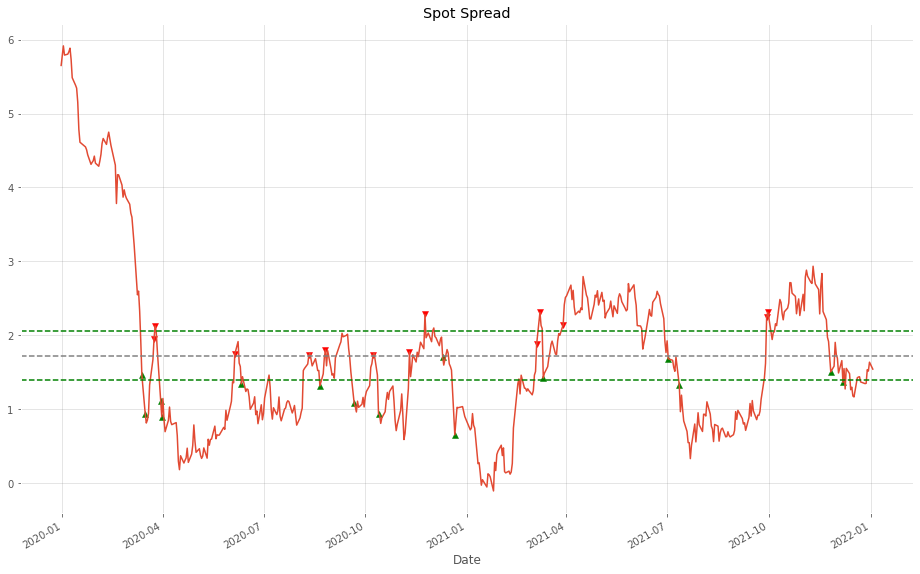

In [22]:
# Backtesting on training set

df_testing['spot_spread'].plot(figsize = (16,10), title = 'Spot Spread', )
plt.axhline(y = (1.719641 + (2 * 0.166)), color = 'green', linestyle = '--')

plt.axhline(y = 1.719641, color = 'grey', linestyle = '--')

plt.axhline(y = (1.719641 - (2 * 0.166)), color = 'green', linestyle = '--')

plt.scatter(x = df_testing[df_testing['buyorsell'] == 1]['spot_spread'].index,
            y = df_testing[df_testing['buyorsell'] == 1]['spot_spread'], marker = '^', color = 'green')

plt.scatter(x = df_testing[df_testing['buyorsell'] == -1]['spot_spread'].index,
            y = df_testing[df_testing['buyorsell'] == -1]['spot_spread'], marker = 'v', color = 'red')

In [23]:
df_testing.loc['2021']

,ING,MS,spot_spread,positive_2std,negative_2std,s_spread_diff,pos,buyorsell,spread_cap_req
Date,,,,,,,,,
2021-01-04,9.27,68.330002,0.717972,2.051641,1.387641,-1.001669,1.0,0.0,17.822029
2021-01-05,9.44,69.489998,0.742789,2.051641,1.387641,-0.976852,1.0,0.0,18.137211
2021-01-06,10.16,73.680000,0.938378,2.051641,1.387641,-0.781263,1.0,0.0,19.381622
2021-01-07,10.16,74.940002,0.780679,2.051641,1.387641,-0.938962,1.0,0.0,19.539321
2021-01-08,10.16,75.250000,0.741880,2.051641,1.387641,-0.977761,1.0,0.0,19.578120
...,...,...,...,...,...,...,...,...,...
2021-12-27,13.91,100.400002,1.344163,2.051641,1.387641,-0.375478,1.0,0.0,26.475837
2021-12-28,13.86,99.970001,1.347980,2.051641,1.387641,-0.371660,1.0,0.0,26.372019
2021-12-29,13.89,98.730003,1.533176,2.051641,1.387641,-0.186464,1.0,0.0,26.246824


In [24]:
df_acc_testing = account(df_testing, 100000, 10)
df_acc_testing

/var/folders/vt/xp_pd8c10sz7qxkl9nb47lrw0000gp/T/ipykernel_1710/536343103.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['open_position'][i:] = data1['pos'][i]


,ING,MS,spot_spread,positive_2std,negative_2std,s_spread_diff,pos,buyorsell,spread_cap_req,cash,...,traded_nominal_val,unrealised_P&L,cashflow,total_assets,net_assets,strat_acc_return_pct_chg,strat_acc_return_nplog_net_assets,cumsum_strat_acc,max_performance_acc,drawdown_acc
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,12.05,51.119999,5.651937,2.051641,1.387641,3.932296,-1.0,NaN,18.448064,100000.000000,...,0.000000,0.000000,0.0,100000.000000,100000.000000,NaN,NaN,NaN,NaN,NaN
2020-01-02,12.43,52.040001,5.916792,2.051641,1.387641,4.197151,-1.0,0.0,18.943209,100000.000000,...,0.000000,0.000000,0.0,100000.000000,100000.000000,0.000000,0.000000,1.000000,1.000000,0.000000
2020-01-03,12.20,51.200001,5.791924,2.051641,1.387641,4.072283,-1.0,0.0,18.608076,100000.000000,...,0.000000,0.000000,0.0,100000.000000,100000.000000,0.000000,0.000000,1.000000,1.000000,0.000000
2020-01-06,12.19,51.020000,5.804452,2.051641,1.387641,4.084811,-1.0,0.0,18.575547,100000.000000,...,0.000000,0.000000,0.0,100000.000000,100000.000000,0.000000,0.000000,1.000000,1.000000,0.000000
2020-01-07,12.21,50.919998,5.836968,2.051641,1.387641,4.117327,-1.0,0.0,18.583032,100000.000000,...,0.000000,0.000000,0.0,100000.000000,100000.000000,0.000000,0.000000,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28,13.86,99.970001,1.347980,2.051641,1.387641,-0.371660,1.0,0.0,26.372019,187562.712951,...,9951.333031,-97.595811,0.0,197514.045982,197416.450171,0.000141,0.000141,1.974165,1.988985,0.014821
2021-12-29,13.89,98.730003,1.533176,2.051641,1.387641,-0.186464,1.0,0.0,26.246824,187562.712951,...,9951.333031,1256.187051,0.0,197514.045982,198770.233033,0.006857,0.006834,1.987702,1.988985,0.001283
2021-12-30,13.88,98.800003,1.514415,2.051641,1.387641,-0.205226,1.0,0.0,26.245585,187562.712951,...,9951.333031,1119.042443,0.0,197514.045982,198633.088425,-0.000690,-0.000690,1.986331,1.988985,0.002654


In [29]:
df_acc_testing['2021-12'].tail()

/var/folders/vt/xp_pd8c10sz7qxkl9nb47lrw0000gp/T/ipykernel_1710/1796526765.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df_acc_testing['2021-12'].tail()


,ING,MS,spot_spread,positive_2std,negative_2std,s_spread_diff,pos,buyorsell,spread_cap_req,cash,...,traded_nominal_val,unrealised_P&L,cashflow,total_assets,net_assets,strat_acc_return_pct_chg,strat_acc_return_nplog_net_assets,cumsum_strat_acc,max_performance_acc,drawdown_acc
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-27,13.91,100.400002,1.344163,2.051641,1.387641,-0.375478,1.0,0.0,26.475837,187562.712951,...,9951.333031,-125.503013,0.0,197514.045982,197388.542969,-0.000839,-0.000839,1.973885,1.988985,0.015100
2021-12-28,13.86,99.970001,1.347980,2.051641,1.387641,-0.371660,1.0,0.0,26.372019,187562.712951,...,9951.333031,-97.595811,0.0,197514.045982,197416.450171,0.000141,0.000141,1.974165,1.988985,0.014821
2021-12-29,13.89,98.730003,1.533176,2.051641,1.387641,-0.186464,1.0,0.0,26.246824,187562.712951,...,9951.333031,1256.187051,0.0,197514.045982,198770.233033,0.006857,0.006834,1.987702,1.988985,0.001283
2021-12-30,13.88,98.800003,1.514415,2.051641,1.387641,-0.205226,1.0,0.0,26.245585,187562.712951,...,9951.333031,1119.042443,0.0,197514.045982,198633.088425,-0.000690,-0.000690,1.986331,1.988985,0.002654
2021-12-31,13.92,98.160004,1.634516,2.051641,1.387641,-0.085125,1.0,0.0,26.205484,187562.712951,...,9951.333031,1996.979566,0.0,197514.045982,199511.025548,0.004420,0.004410,1.995110,1.995110,0.000000


In [27]:
np.sqrt(252) * (np.exp(df_acc_testing['strat_acc_return_nplog_net_assets'].mean()) - 1) / (np.exp(df_acc_testing['strat_acc_return_nplog_net_assets'].std()) - 1)

0.8927677348230357

In [28]:
(df_acc_testing['strat_acc_return_pct_chg'].mean() / df_acc_testing['strat_acc_return_pct_chg'].std()) * np.sqrt(252)

1.0624987971120845

In [ ]:
np.exp(df_acc_testing['strat_acc_return_nplog_net_assets'].sum())

In [30]:
df_acc_testing['drawdown_acc'].max()

0.23377794591417733